## Key References

- Main reference: [A Practical Guide to Surface Kinetic Monte Carlo Simulations (2019)](https://www.frontiersin.org/articles/10.3389/fchem.2019.00202/full)
- [A kinetic Monte Carlo approach to diffusion-controlled thermal desorption spectroscopy (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5468722/)
    - "As the time step depends on the temperature through the rate constants and the temperature changes with time, the time scale within the simulations must be comparable to experimental time scales to obtain meaningful results. Care must be taken if the starting temperature of the KMC simulation is too low as this would result in artificially large time steps and correspondingly large jumps in the temperature, and thus many processes that should have already occurred at lower T would be skipped... ... It is thus necessary either to carefully choose a suitable starting temperature, which is only possible if the process rates are homogeneous, or to limit the time step and only perform a KMC step if: $\Delta t(T_{1}) < t_{0} + \Delta t (T_{1} + \beta \Delta t_{0})$."
    - *This tells us that we need to carefully limit the maximum temperature change between KMC steps to avoid the simulation potentially skipping important processes*.
- [Kinetic Monte Carlo - slide deck (2006)](https://www.mv.helsinki.fi/home/knordlun/mc/mc8nc.pdf)
    - "Moreover, if we use Eq. 1 to derive the event probability in our simulations, we get the added advantage that we can do simulations at any temperature realistically, even if the temperature keeps changing during the modeling."
    - *This tells us that we don't have to equilibriate each time we change temperature, we just have to carefully limit the maximum temperature change.*
    

## To-Do
- Decide which file(s) the `pairwisedists()` and `rates()` functions should go in.
- How should we choose the limit for maximum temperature change between KMC steps?
- Should we continue to make the recorded sample steps a multiple of elementary KMC steps, or should we try something else?
    - The current issue is that the time intervals between sample steps at lower temperatures shouldn't be much, much larger than those at higher temperatures.
- What should the amplitude (and lattice constant) of the triangular lattice energies be in Andrew's code?
    - What boxsize allows the triangular lattice energies to be approximately periodic at the boundaries?

## Code

In [1]:
import cupy as cp
import matplotlib.pyplot as plt
from numba.core.errors import NumbaPerformanceWarning
import numpy as np
import scipy as sp
import sys
import warnings
warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

sys.path.append('..')
from src.constants import *
from src.energy import *
from src.lattice import *
from src.plotter import *

# To generate requirements.txt: pip freeze > requirements.txt
# To generate environment.yml: conda env export --name kagomekmc --file environment.yml
# To update environment.yml: conda env update --prefix ./env --file environment.yml --prune
# To create from environment.yml: conda env create --prefix ./env --file environment.yml --force

Determine the ideal box width that satisfies periodic boundary conditions for the triangular lattice potential

In [17]:
ideal_boxwidths(show_topn=10)

tle_x (first and last value): 8, 308

kl_x (first and last value): 7.872, 308.238

Ideal box widths (sorted by L2-norm error):
#1: 104.058nm | L2-norm error: 0.0714
#2: 235.914nm | L2-norm error: 0.1083
#3: 208.116nm | L2-norm error: 0.1427
#4: 131.856nm | L2-norm error: 0.1460
#5: 207.870nm | L2-norm error: 0.1543
#6: 55.842nm | L2-norm error: 0.1618
#7: 27.798nm | L2-norm error: 0.2027
#8: 263.712nm | L2-norm error: 0.2921
#9: 235.668nm | L2-norm error: 0.3385
#10: 159.654nm | L2-norm error: 0.3461


Generated 20 molecule indices in 1 attempts.
System box dimensions (nm): (7.8720, 7.6695)
Number of Kagome unit cells (columns, rows): (32, 18)
Number of total Kagome lattice sites: 3456


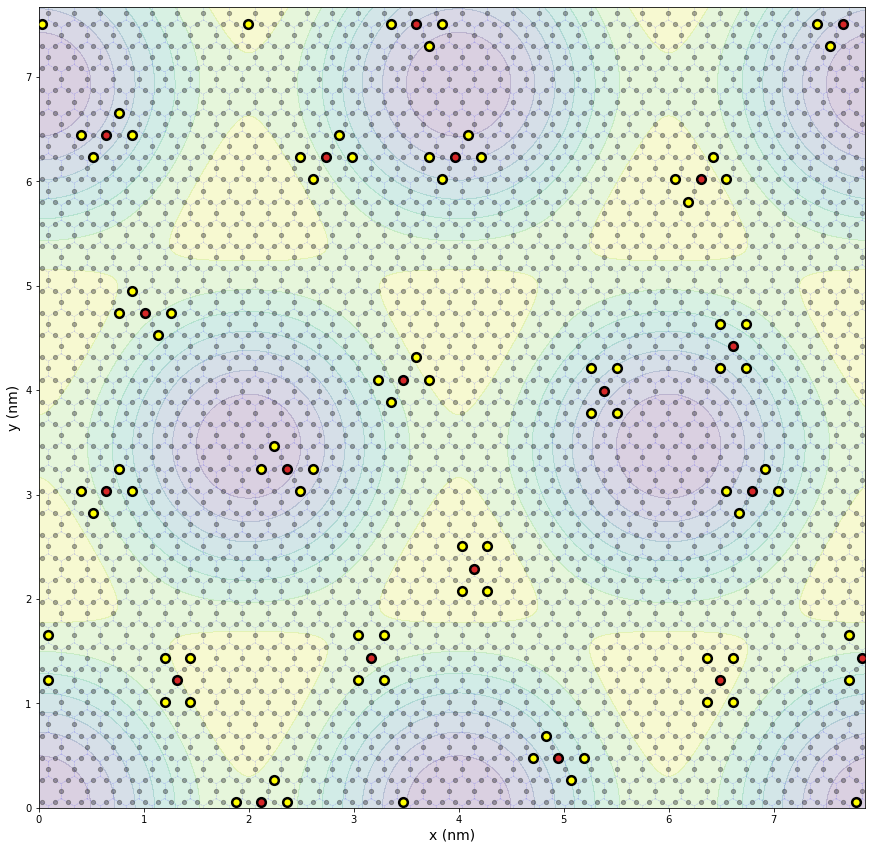

In [18]:
boxwidth = 8
n_molecules = 20

# Initialize the simulation lattice
kagome = KagomeLattice(boxwidth=boxwidth)
# Get array of all lattice sites xy-coordinates
lxy = kagome.get_latticesites()
# Get array of all nearest neighbor indices for each lattice site
mnnids = kagome.get_sitennids(cp.arange(lxy.shape[0], dtype='int32'))
# Get array of random molecule position indices
if n_molecules > 0: mids = kagome.generate_randomids(n_molecules=n_molecules, sites=lxy, n_attempts=1000, threshold=5)
# Define the lattice energy surface (here, a triangular lattice potential)
tle = TriangularLatticeEnergies(lattice_constant=4.0, amplitude=1.0)
print(f"System box dimensions (nm): ({kagome.boxsize[0]:.4f}, {kagome.boxsize[1]:.4f})")
print(f"Number of Kagome unit cells (columns, rows): {kagome.n_unitcells}")
print(f"Number of total Kagome lattice sites: {kagome._n_totalsites}")

fig, ax = plt.subplots(figsize=(12, 12*figsize_yscale(kagome)), layout='constrained', dpi=72)
# Plot the lattice energy surface
ax = plot_latticeenergies(ax, tle, kagome.boxsize, shift=[0., 0.], nsamples=1000, cmap='viridis', alpha=0.2, zorder=1)
if boxwidth <= 10:
    # Plot the graphene lattice bonds
    ax = plot_graphenebonds(ax, kagome, colors='b', lw=0.5, ls='--', alpha=0.25, zorder=2)
    # Plot the Kagome lattice sites
    ax = plot_kagomesites(ax, kagome, s=18, c='k', ec='k', alpha=0.3, zorder=3)
if n_molecules > 0:
    # Plot the molecules
    ax = plot_molecules(ax, lxy[mnnids[mids]].get(), show_nn=True, s=75)
ax.set(xlim=kagome.xlim, ylim=kagome.ylim)
ax.set_xlabel('x (nm)', fontsize=14)
ax.set_ylabel('y (nm)', fontsize=14)
plt.show()

In [ ]:
# def cupy_spline_opt(lxy, nnids, dims, mids, steps, temp, interpfunc, userands=None, targetrates=None, seed=None, inttype='int32', floattype='float64'):
#     '''List of optimizations:
    
#     - Combined molecule and NN arrays into one array which is not only more memory efficient, but also only needs one distance and energy calculation.
#     - ?
    
#     '''
#     cp.random.seed(seed=seed)
#     lnnids = cp.concatenate([cp.arange(lxy.shape[0], dtype=inttype).reshape(-1,1), nnids], axis=1, dtype=inttype)
#     n_molecules = mids.shape[0]
#     times = cp.zeros((steps+1), dtype=floattype)
#     ids = cp.zeros((steps+1, n_molecules), dtype=inttype)
#     ids[0,:] = mids
#     rands = cp.random.uniform(0., 0.999999, size=(steps, 2)) if userands is None else cp.array(userands)
#     step_times = np.zeros((steps,), dtype='float64')
#     step_errors = np.array([], dtype='float64')
#     step_chosenIDs = np.zeros((steps,), dtype='int64')
#     step_rates = []

#     for i in range(steps):
#         print(f'CuPy Cubic Spline (Optimized)  |  Step {i+1}  |  {int(n_molecules)} molecules', end='\r', flush=True)
#         start_gpu = cp.cuda.Event()
#         end_gpu = cp.cuda.Event()
#         start_gpu.record()
#         start_cpu = time.perf_counter()
#         ids[i+1] = ids[i]
#         times[i+1] = times[i] 
#         mnnxy = lxy[lnnids[ids[i+1]]]
#         mnndists = cupy_dists_v3(mnnxy, dims)
#         cp.einsum('iji->ij', mnndists)[...] = 0.0
#         mnnenergies = interpfunc(mnndists)
#         mnnenergies = cp.sum(mnnenergies, axis=2)
#         rates = cupy_rates(mnnenergies[:,0], mnnenergies[:,1:], temperature=temp)
#         Kcumsum = cp.cumsum(rates)
#         chosenK_id = cp.searchsorted(Kcumsum, rands[i,0]*Kcumsum[-1], side="right")
#         mol_id = chosenK_id // 4
#         nn_id = chosenK_id % 4
#         ids[i+1,mol_id] = nnids[ids[i+1]][mol_id,nn_id]
#         times[i+1] += -cp.log(rands[i,1]) / Kcumsum[-1]
#         end_cpu = time.perf_counter()
#         end_gpu.record()
#         end_gpu.synchronize()
#         step_times[i] = (cp.cuda.get_elapsed_time(start_gpu, end_gpu) * 1e-3) + (end_cpu - start_cpu)
#         step_chosenIDs[i] = chosenK_id
#         if targetrates is not None:
#             step_errors = np.hstack([step_errors, np.mean(targetrates[i] - rates.get())])
#         else:
#             step_rates.append(rates.get())
#     rands = rands.get() if userands is None else rands
#     return (step_times, step_errors, step_rates, rands, step_chosenIDs)

# KL_cpu = KagomeLattice(boxsize=boxsize, lattice_constant=lattice_constant, usegpu=False)
# LXY = KL_cpu.get_lattice_sites
# NNIDS = KL_cpu.mnnids(np.arange(LXY.shape[0]))[:,1:]
# BDIMS = KL_cpu.dims
# LXYcp = cp.array(LXY, dtype=floattypes)
# NNIDScp = cp.array(NNIDS, dtype=inttypes)
# BDIMScp = cp.array(BDIMS)
# test_distances = cp.linspace(0.246, 200.0, 20000)
# test_energies_cp = cupy_energies(test_distances, Zval=1.0, epsr=4.22)
# cp_spline = CpCubicSpline(test_distances, test_energies)